# MSDS7333 Case Study 2: Signal Frontier Analysis
## Calculating a Momentum Portfolio
Julien Bataillard
Jared Law
Dennis Murray
Cory Nichols

In [263]:
import datetime as dt

import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [264]:
# set date range
date_time_start = dt.datetime(2016, 1, 1)
date_time_end = dt.datetime(2017, 6, 1)

In [265]:
# add SPY (S&P 500 Index) to check for market correlations, comparisons for returns
def get_portfolio():
    ''' Get portfolio of stocks using buggy Yahoo'''
    
    port = pd.DataFrame()
    names = ['DPZ', 'PZZA', 'YUM', 'FRSH', 'MCD', 'KHC', 'PLAY','SPY']
    for stock in names:
        while True:
            try:
                port[stock] = web.get_data_yahoo(stock, date_time_start, date_time_end)['Adj Close']
                break
            except:
                print('Unable to read stock: {0}, trying again'.format(stock))
    return port

px = get_portfolio()
px = px.loc[~(px==0).all(axis=1)] # strip out days with no trading data for all stocks

Unable to read stock: DPZ, trying again


In [266]:
# daily adjusted close prices for pizza portfolio 
px.head()

DPZ       PZZA        YUM   FRSH         MCD        KHC  \
Date                                                                         
2016-01-04  107.016136  53.639576  49.635929  10.92  111.198700  68.692657   
2016-01-05  107.701935  53.414898  49.512199  10.77  112.730759  69.344627   
2016-01-06  107.545174  51.363480  49.161636  11.23  111.974197  69.476913   
2016-01-07  104.586395  49.546516  47.484421  10.71  109.382896  67.936745   
2016-01-08  106.761391  47.504875  46.838276  10.26  109.212654  67.256439   

                 PLAY         SPY  
Date                               
2016-01-04  41.709999  193.041077  
2016-01-05  41.889999  193.367584  
2016-01-06  42.439999  190.928375  
2016-01-07  41.209999  186.347717  
2016-01-08  39.509998  184.302277

In [267]:
# pepperoni pizza?
px.describe()

DPZ        PZZA         YUM        FRSH         MCD         KHC  \
count  357.000000  357.000000  357.000000  357.000000  357.000000  357.000000   
mean   150.081639   70.684679   60.116682    6.822717  119.307897   82.016308   
std     26.632106   12.199153    5.646775    2.500708    8.940297    6.572037   
min    102.048889   44.447296   45.143360    3.780000  106.960632   65.385567   
25%    128.977921   59.137615   56.927414    4.650000  112.730759   78.209389   
50%    148.811310   74.692879   61.966843    6.030000  117.558563   84.319641   
75%    169.237442   79.682266   63.460941    8.475000  122.494331   86.370911   
max    216.474655   88.525841   73.412682   12.810000  151.927551   93.931450   

             PLAY         SPY  
count  357.000000  357.000000  
mean    47.435770  211.095685  
std      9.581822   15.865322  
min     31.080000  175.601883  
25%     39.470001  200.518143  
50%     45.330002  210.308289  
75%     56.189999  223.210510  
max     68.639999  240.555542

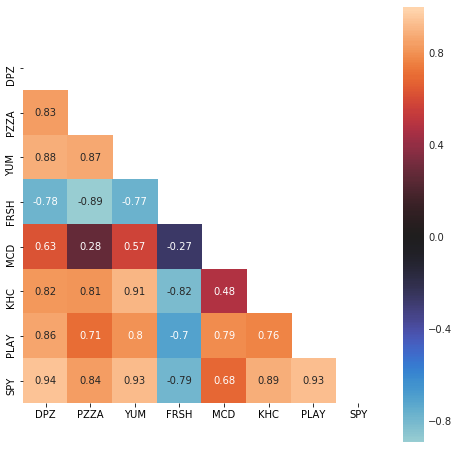

In [268]:
# check linear relationships
corr = px.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)

Pizza Stocks mostly outperform SP 500 Greatly


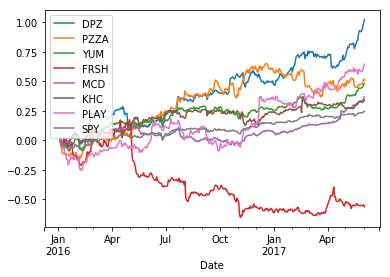

In [269]:
# transform to business day frequency and calculate percentage change
# show cumulative returns over time period of business days

px = px.asfreq('B').fillna(method='pad') # pad == ffill
rets = px.pct_change() #default is one, business day return
print('Pizza Stocks mostly outperform SP 500 Greatly')
((1+rets).cumprod()-1).plot()
plt.show()

In [270]:
# potential reference: https://www.investopedia.com/terms/m/momentum_investing.asp
# compute momentum over a lookback and rank in descending order and standardize to get portfolio weights
# this is not momentum out of the box. this is mean reversion, we can change to momentum by changing asc to Ture
# these form the weights for our portfolio and are based on standardized momentum ranks so we sum to 0 as part of
# our portfolio
# ascending = True - momentum
# ascending = False - mean reversion

def calc_mom(price, lookback, lag):
    '''Calculates pct change based on user input shift and lookback period, ranks, then standardizes ranks'''
    mom_ret = price.shift(lag).pct_change(lookback) # price shift forward lag periods and calc % change based on
                                                    # lookback cumulative return for each day in index
    ranks = mom_ret.rank(axis=1, ascending=True) # rank top performers for each day (ASCENDING = MAXIMIZE STOCKS
                                                  # WITH POSITIVE TREND)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0) # subtract the mean rank for the portfolio for each day
    return demeaned.divide(demeaned.std(axis=1), axis=0) # divide by sd of the ranks for each day to standardize

Now set up backtesting function to calculate a portfolio 

by iterating over lookbacks and holding period

In [272]:
compound = lambda x : (1+x).prod()-1     # compound calc to give us compound returns for each holding period
daily_sr = lambda x : x.mean() / x.std() # calculate mean portfolio return divided by std deviation to get sharpe

# Sharpe Ratio is avg return above risk free rate 
# Subtracting the risk-free rate from the mean return, 
# the performance associated with risk-taking activities can be isolated.
# > sharpe ratio = more attractive risk adjusted return
# (https://www.investopedia.com/terms/s/sharperatio.asp)

def strat_sr(prices, lb, hold):
    # Compute portfolio weights using rank-standardized momentum portfolio
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    return port_rets, daily_sr(port_rets) * np.sqrt(252 / hold) 
    
    # THE ANSWER HAS BEEN REVEALED (regarding sharpe ratio scaling which is an annual value inherently)
    # the scaling factor is an approximation,  
    # We use K as a scaling factor to adjust for the cases when our data is sampled more frequently than annually
    # https://augmentedtrader.com/2015/09/02/why-multiply-by-sqrt252-to-compute-the-sharpe-ratio/

In [312]:
# sharpe ratio comparison setup
from collections import defaultdict

lookbacks = range(10, 200, 10)
holdings = range(10, 200, 10)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px.iloc[:,:-1], lb, hold)[1]
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [313]:
def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

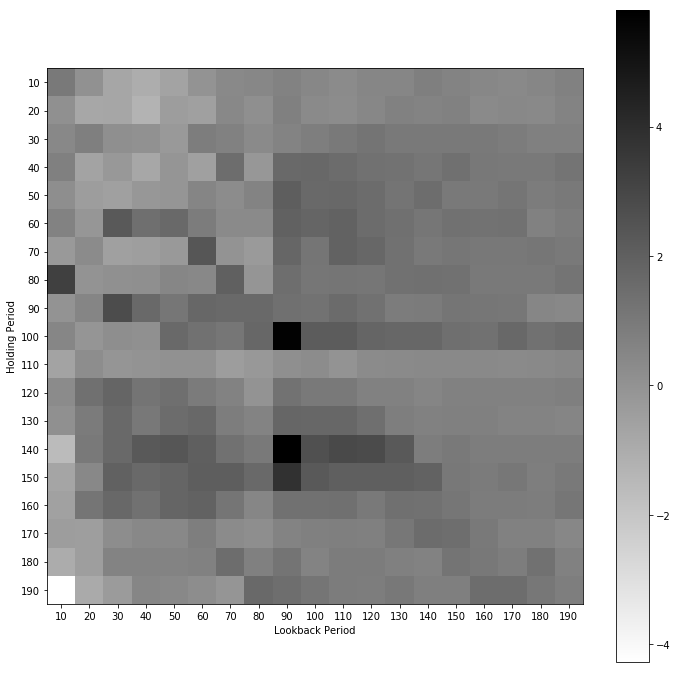

In [314]:
heatmap(ddf)
plt.show()

In [315]:
# compare returns to S&P cumulative return
sp_sharpe = px['SPY'].pct_change()
sp_sharpe = sp_sharpe.mean()/sp_sharpe.std()*np.sqrt(252)
print(round(sp_sharpe,3))

1.379


In [316]:
print(sum((ddf>1.3786213071404394).values.reshape(-1)), 'combinations with higher sharpe then S&P 500')
ddf[ddf>sp_sharpe].dropna(how='all',axis=[0,1]).fillna('')
# holding period of 60, 90+ days looks promising - makes sense given intermediate term momemntum investing
# has been proven to work better than short term or long term

82 combinations with higher sharpe then S&P 500


Lookback Period      10       20       30       40       50       60   \
Holding Period                                                          
40                                                                      
50                                                                      
60                                 2.27666  1.39307  1.64941            
70                                                             2.3995   
80               3.26872                                                
90                                 2.79821  1.62694           1.73784   
100                                                  1.63512            
120                       1.38759  1.81401           1.42753            
130                                1.66548            1.5364   1.6928   
140                                1.60289  2.29234  2.40581  2.05794   
150                                1.93068  1.60319  1.82343  2.09139   
160                                 1.6865            1.8061  1.86752   
170                                                                     
180                                                                     
190                                                                     

Lookback Period      70       80       90       100      110      120  \
Holding Period                                                          
40               1.48589           1.60737   1.6851  1.51783            
50                                 2.08704   1.6452  1.68484  1.51129   
60                                 1.95672  1.81231  1.87996  1.54393   
70                                 1.78078             1.892  1.73541   
80               1.99676           1.43593                              
90               1.65013   1.5912                    1.58485            
100                       1.70745  5.67479  2.15634  2.15634  1.82377   
120                                                                     
130                                1.75019  1.73819  1.73921  1.41614   
140                                5.80179  2.62933   2.8997  2.81703   
150              2.08804  1.64019  3.80032  2.21989  2.03009  2.04316   
160                                                                     
170                                                                     
180              1.49982                                                
190                       1.65945  1.45311                              

Lookback Period      130      140      150      160      170      190  
Holding Period                                                         
40                                                                     
50                        1.48661                                      
60                                                                     
70                                                                     
80                        1.38147                                      
90                                                                     
100              1.72259  1.72563  1.39342           1.70619  1.47993  
120                                                                    
130                                                                    
140              2.23384                                               
150              2.02342  1.86806                                      
160                                                                    
170                       1.53019  1.43563                             
180                                                                    
190                                         1.50868  1.50868

In [361]:
df = ddf[ddf>sp_sharpe].dropna(how='all',axis=[0,1])
# holding period optimal 150
df.loc[df.notnull().sum(axis=1).idxmax(),:]

Lookback Period
10          NaN
20          NaN
30     1.930678
40     1.603191
50     1.823427
60     2.091389
70     2.088039
80     1.640190
90     3.800323
100    2.219885
110    2.030089
120    2.043164
130    2.023417
140    1.868063
150         NaN
160         NaN
170         NaN
190         NaN
Name: 150, dtype: float64

In [354]:
# LB Period optimal 90
df[df.notnull().sum(axis=0).idxmax()]

Holding Period
40     1.607374
50     2.087041
60     1.956725
70     1.780778
80     1.435926
90          NaN
100    5.674790
120         NaN
130    1.750191
140    5.801789
150    3.800323
160         NaN
170         NaN
180         NaN
190    1.453105
Name: 90, dtype: float64